In [1]:
import pybammeis
import pybamm
import os
import re
import numpy as np
from gamry_parser import GamryParser, Impedance
import pandas as pd
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft
import random
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.interpolate import interp1d
import pyswarms as ps 

Plotting experimental EIS data

2.797814531945193


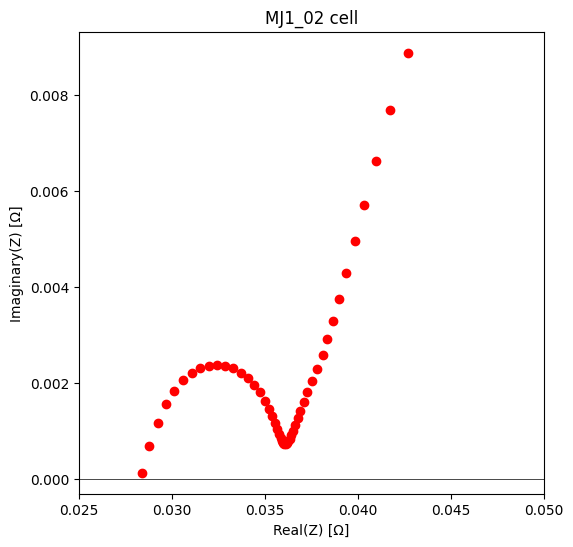

In [2]:
file = "/Users/synnemard/Desktop/lithium_ion/EIS data/MJ1_02.DTA"
# Information about the MJ1_02 cell: 
# ved BoL (Beginning of Life)
# ved ca. 45% SoC 
# ved 25 deg C

ca = Impedance(file)
ca.load(filename=file)

# process data header metadata to get start_time (not strictly necessary)
start_time = pd.Timestamp("{} {}".format(ca.header.get("DATE"), ca.header.get("TIME")))
    
# extract EIS curve
res = ca.get_curve_data()
res_reverse = res.iloc[::-1]
df_mag = res_reverse['Zmod']
df_phz = res_reverse['Zphz']
df_real = res_reverse['Zreal']
df_imag= res_reverse['Zimag']
freq = res_reverse['Freq']

# excluding the values in the 4th quadrant: 
df_mag = df_mag[:49]
df_phz = df_phz[:49]
df_real = df_real[:49]
df_imag = df_imag[:49]
freq = freq[:49]


# Create Nyquist plot
plt.figure(figsize=(6,6))
plt.scatter(df_real, -df_imag, color='red')  # To plot points

# Labeling the plot
plt.axhline(0, color='black',linewidth=0.5)  # X-axis
plt.axvline(0, color='black',linewidth=0.5)  # Y-axis
plt.xlim(0.025, 0.05)
#plt.ylim(0, 0.015)
plt.xlabel('Real(Z) [Ω]')
plt.ylabel('Imaginary(Z) [Ω]')
plt.title('MJ1_02 cell')


#finner høyeste log frekvens 
x = np.log10(freq[22])
print(x)

# Show plot
plt.show()


Generating EIS simulation

Assumptions:
- DFN model
- same parameters as I got from Amund
- input parameter SoC - 45% 
- at 25 degrees C
- using the numerical prebicgstab frequency domain method and also the time domain method

Defining Parameters

In [3]:
# OCV curves for the anode and cathode
# Simple math model for the individual electrode potentials as a function of the stoichiometry of Lithium
def MJ1_ocp_tanh_SiC(sto):
    x = sto
    p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])
    
    return (
            p[0] * pybamm.exp(-p[1] * x)
            + p[2]
            - p[3] * pybamm.tanh(p[4] * (x - p[5]))
            - p[6] * pybamm.tanh(p[7] * (x - p[8]))
            - p[9] * pybamm.tanh(p[10] * (x - p[11]))
        )

def MJ1_ocp_tanh_NMC(sto):
    x = sto
    p = np.array([ 0.74041974,  4.39107343,  0.03434767, 18.16841489,  0.53463176, 17.68283504, 14.59709162,  0.28835348, 17.58474971, 14.69911523,  0.28845641])

    return (
            -p[0] * x
            + p[1]
            - p[2] * pybamm.tanh(p[3] * (x - p[4]))
            - p[5] * pybamm.tanh(p[6] * (x - p[7]))
            + p[8] * pybamm.tanh(p[9] * (x - p[10]))
        )

# Parameters from literature
literature_params = {
    'Electrode height [m]': 0.059,
    'Electrode width [m]': 0.610*2, # Multiplying by two since the electrode has active material on both sides.
    'Lower voltage cut-off [V]': 2.5,
    'Upper voltage cut-off [V]': 4.5,
    'Nominal cell capacity [A.h]': 3.5,

    # From Table 3 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Maximum concentration in negative electrode [mol.m-3]': 32418.5,
    'Negative particle radius [m]': 6.1e-06,
    'Negative electrode porosity': 0.216,
    'Negative electrode active material volume fraction': 0.7011854763922494,
    'Negative electrode conductivity [S.m-1]': 100.0,
    'Negative electrode diffusivity [m2.s-1]': 5e-14,
    'Negative electrode OCP [V]': MJ1_ocp_tanh_SiC,

    # 'Maximum concentration in positive electrode [mol.m-3]': 51081.15,
    'Positive particle radius [m]': 3.8e-06,
    'Positive electrode porosity': 0.171,
    'Positive electrode active material volume fraction': 0.7355902286855152,
    'Positive electrode conductivity [S.m-1]': 0.17,
    'Positive electrode diffusivity [m2.s-1]': 5e-13,
    'Positive electrode OCP [V]': MJ1_ocp_tanh_NMC,

    'Separator porosity': 0.45,

    # end of section 3 data
    
    # From Table A-9 and A-10 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Negative current collector conductivity [S.m-1]': 5.9e7/(1+3.383e-3 * (298.15-293.15)), 
    'Negative current collector thickness [m]': 11e-06,
    'Negative current collector density [kg.m-3]': 8950.0,
    'Negative current collector specific heat capacity [J.kg-1.K-1]': 385.0,
    'Negative current collector thermal conductivity [W.m-1.K-1]': 398.0,
    'Negative electrode density [kg.m-3]': 2242.0,
    'Negative electrode specific heat capacity [J.kg-1.K-1]': 867.0,
    'Negative electrode thermal conductivity [W.m-1.K-1]': 1.04,
    'Negative electrode thickness [m]': 86.7e-6, # 86.7 in Sturm 2019, 85um in Heenan2020, 170um in NASA
    'Positive current collector conductivity [S.m-1]': 3.78e7/(1+4.290e-3 * (298.15-293.15)),
    'Positive current collector density [kg.m-3]': 2710.0,
    'Positive current collector specific heat capacity [J.kg-1.K-1]': 903.0,
    'Positive current collector thermal conductivity [W.m-1.K-1]': 238.0,
    'Positive current collector thickness [m]': 17.3e-06,
    'Positive electrode density [kg.m-3]': 4870.0,
    'Positive electrode specific heat capacity [J.kg-1.K-1]': 840.1,
    'Positive electrode thermal conductivity [W.m-1.K-1]': 1.58,
    'Positive electrode thickness [m]': 66.2e-6, #66.2um in Sturm2019, 72.5um in Heenan2020, 160um in NASA
    'Separator density [kg.m-3]': 1009.0,
    'Separator specific heat capacity [J.kg-1.K-1]': 1978.2,
    'Separator thermal conductivity [W.m-1.K-1]': 0.33,
    'Separator thickness [m]': 12e-06,
    # end of table data
    }

# Use default parameters from the Chen2020 publication
params = pybamm.ParameterValues("Chen2020")

# Overwrite parameters with our own
for parameter, value in literature_params.items():
    try:
        if params[parameter] != value: # Check if the parameter exists in 'params' and has a different value
            params[parameter] = value # Update 'params' with the new value from 'literature_params'
    except KeyError as e: # This block handles the case where the 'parameter' is not in 'params'
        print(f"Parameter {parameter} not part of default. Skipping.")

# Changing state of charge SOC
z = 0.45

x0, x100, y100, y0 = pybamm.lithium_ion.get_min_max_stoichiometries(params)
x = x0 + z * (x100 - x0)
y = y0 - z * (y0 - y100)
c_n_max = params["Maximum concentration in negative electrode [mol.m-3]"]
c_p_max = params["Maximum concentration in positive electrode [mol.m-3]"]

params.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y * c_p_max,
    }
)

# params['Initial temperature [K]'] = ambient temperature = 25 degrees

# Choosing the same frequency range as in the experimental plot. 
# x is ish equal to 2.8
frequencies = np.logspace(-2, 2.8, 49)




Updating parameters I think is incorrect: 

- overflateareal mellom elektrode og elektrolytt - surface area between electrode and electrolyte
Instead: The electrode thicknesses or adjust the Bruggeman coefficient for the electrolyte (reduces ion transport which lowers interaction between the electrolyte and electrode)

- Electrolyte conductivity 

- (feil porositet)

In [4]:
model1 = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
dic1 = model1.get_parameter_info() #49
model2 = pybamm.lithium_ion.DFN() 
dic2 = model2.get_parameter_info() #47

diff_keys = set(dic1.keys()) - set(dic2.keys())
print(diff_keys)

# Her ser vi at den positive og negative electrode double-layer capacity kan bli endret!

{'Positive electrode double-layer capacity [F.m-2]', 'Negative electrode double-layer capacity [F.m-2]'}


In [5]:
# har fjernet nominal cell capacity og Bruggeman coefficient foreløpig 

initial_params = [
    float(params['Negative electrode thickness [m]']), 
    #float(params['Negative electrode Bruggeman coefficient (electrolyte)']),
    # float(params['Nominal cell capacity [A.h]']),  
    float(params['Separator thickness [m]']),
    float(params['Negative electrode double-layer capacity [F.m-2]']), 
    float(params['Positive electrode double-layer capacity [F.m-2]']), 
    float(params['Electrode width [m]'])
    
    ]

print(initial_params)


[8.67e-05, 1.2e-05, 0.2, 0.2, 1.22]


In [8]:
real_exp = np.array(df_real)
imag_exp = np.array(df_imag)

#options={"surface form": "differential"}

def Z_sim(frequencies, upt_par):
  model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
  #options={"surface form": "differential"}
  params.update(
    {'Negative electrode thickness [m]': upt_par[0], 
     #'Negative electrode Bruggeman coefficient (electrolyte)': upt_par[1], 
     #'Positive electrode Bruggeman coefficient (electrolyte)': upt_par[1], 
     #'Separator Bruggeman coefficient (electrolyte)': upt_par[1], 
     #'Nominal cell capacity [A.h]': upt_par[2], 
     'Separator thickness [m]': upt_par[1], 
     'Negative electrode double-layer capacity [F.m-2]': upt_par[2], 
     'Positive electrode double-layer capacity [F.m-2]': upt_par[3], 
     'Electrode width [m]': upt_par[4] 
     })
  eis_sim = pybammeis.EISSimulation(model, parameter_values=params)
  z_sim = eis_sim.solve(frequencies, method = "prebicgstab")
  return z_sim 


def diff_function(upt_par, frequencies, real_exp, imag_exp): 
  imp_sim = Z_sim(frequencies, upt_par)
  real_sim = np.real(imp_sim)
  imag_sim = np.imag(imp_sim)

  real_diff = real_sim - real_exp 
  imag_diff = imag_sim - imag_exp 

  #the total sum of squared differences (magnitude, absolute value, of the complex differences)
  sum_square_diff = np.sum(real_diff**2 + imag_diff**2)
  return sum_square_diff

#diff_function(initial_params, frequencies, real_exp, imag_exp)

# to pass the additional arguments
# args = (frequencies, real_exp, imag_exp)
def wrapped_diff_function(upt_par):
  return np.array([diff_function(par, frequencies, real_exp, imag_exp) for par in upt_par])

In [9]:

lower_bounds = [50e-6,5e-6,0.01,0.01, 40e-2]
upper_bounds = [300e-6,50e-6,0.2,0.2, 2]
bounds = (lower_bounds, upper_bounds)

n_dim = 5 # changing 5 parameters

options = {'c1': 0.5,      # Cognitive parameter (influence of personal best)
    'c2': 0.3,      # Social parameter (influence of global best)
    'w': 0.9,       # Inertia parameter (how much particles retain velocity)
    }

optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=n_dim, options=options, bounds=bounds)

best_cost, best_params = optimizer.optimize(wrapped_diff_function, iters=2)

print(initial_params)
print("Optimized Parameters:", best_params)
print("Best Cost:", best_cost)



2024-10-02 12:49:24,246 - pyswarms.single.global_best - INFO - Optimize for 2 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|2/2, best_cost=0.00193
2024-10-02 12:49:34,469 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0019271133077114846, best pos: [2.96615898e-04 4.13781362e-05 1.34568499e-02 9.48632105e-02
 1.21620828e+00]


[8.67e-05, 1.2e-05, 0.2, 0.2, 1.22]
Optimized Parameters: [2.96615898e-04 4.13781362e-05 1.34568499e-02 9.48632105e-02
 1.21620828e+00]
Best Cost: 0.0019271133077114846


In [10]:

params.update(
    { 'Negative electrode thickness [m]': best_params[0],
      #'Negative electrode Bruggeman coefficient (electrolyte)': opt_params[1],
      #'Positive electrode Bruggeman coefficient (electrolyte)': opt_params[1],
      #'Separator Bruggeman coefficient (electrolyte)': opt_params[1], 
      #'Nominal cell capacity [A.h]': opt_params[2], 
      'Separator thickness [m]': best_params[1], 
      'Negative electrode double-layer capacity [F.m-2]': best_params[2], 
      'Positive electrode double-layer capacity [F.m-2]': best_params[3],
      'Electrode width [m]': best_params[4]
     
     }
    )


The general model 

In [11]:
model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
#options={"surface form": "differential"}

# Create simulation
eis_sim = pybammeis.EISSimulation(model, parameter_values=params)


#model.print_parameter_info()

Model solved in the frequency domain (with prebicgstab method)

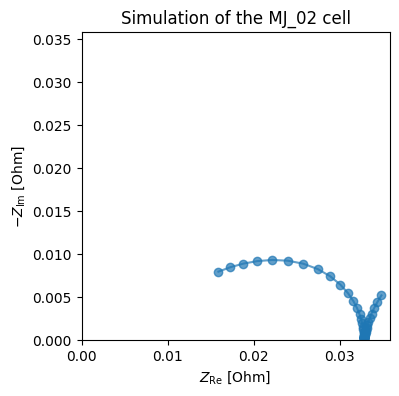

In [12]:
sim_f = eis_sim.solve(frequencies, method = "prebicgstab")

# Plotting the simulation (from frequency domain)
fig, ax = plt.subplots(figsize=(4, 4)) 
pybammeis.nyquist_plot(sim_f, ax=ax, linestyle="-", label=f"Simulation", alpha=0.7
    )
#ax.set_xlim(0.0475, 0.0550) 
#ax.set_ylim(0, 0.008)

#plt.legend()
plt.title('Simulation of the MJ_02 cell')
plt.show() 

Model solved in the time domain (with sinus current)

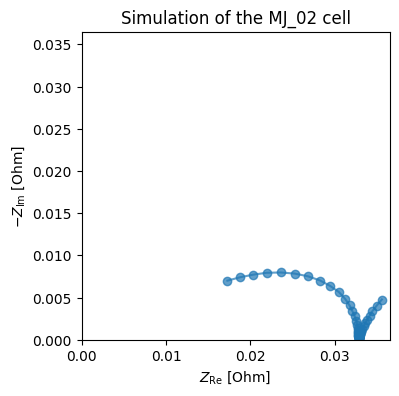

In [13]:

# Time domain
I_app = 0.07 # 10% av output current
number_of_periods = 1 
samples_per_period = 50
# Ser ut som man kan putte inn number of periods og samples per period også
# Ann_Mari snakket om at jeg bare trengte én periode og 50 samples per periode. 


def current_function(t):
    return I_app * pybamm.sin(2 * np.pi * pybamm.InputParameter("Frequency [Hz]") * t)


params["Current function [A]"] = current_function
# Oppdaterer parametrene til å ha en current function!! 


sim_t = pybamm.Simulation(model, parameter_values=params)
# Så simuleringen avhenger av modellen, parametermodellen, osv. 

impedances_time = []
for frequency in frequencies:
    # Solve
    period = 1 / frequency
    dt = period / samples_per_period
    t_eval = np.array(range(0, samples_per_period * number_of_periods)) * dt
    sol = sim_t.solve(t_eval, inputs={"Frequency [Hz]": frequency})
    # Extract final two periods of the solution
    time = sol["Time [s]"].entries[-5 * samples_per_period :]
    current = sol["Current [A]"].entries[-5 * samples_per_period :]
    voltage = sol["Voltage [V]"].entries[-5 * samples_per_period :]
    # Vet ikke hvorfor man starter listene så langt bak? 
    # FFT - Fourier transform av current og voltage! 
    current_fft = fft(current)
    voltage_fft = fft(voltage)
    # Get index of first harmonic - the fundamental frequency itself (representing the primary sine wave)
    # Higher harmonics are multiples of this base frequency and contribute to the overall wave shape. 
    # Since they only find the first harmonic - are they assuming that the response is pseudo-linear? 
    idx = np.argmax(np.abs(current_fft))
    impedance = -voltage_fft[idx] / current_fft[idx]
    impedances_time.append(impedance)


# Plotting the simulation (from the time domain)
fig, ax = plt.subplots(figsize=(4, 4)) 
pybammeis.nyquist_plot(impedances_time, ax=ax, linestyle="-", label=f"Simulation", alpha=0.7
    )
#ax.set_xlim(0.0475, 0.0550) 
#ax.set_ylim(0, 0.008)

#plt.legend()
plt.title('Simulation of the MJ_02 cell')
plt.show() 



Comparing the experimental and the simulated EIS

(and also the ECM model)

Optimization of ECM parameters

In [36]:
# Randles components parameters 
R_el = 27.5e-3 #Electrolyte resistance (Ohms)
R_ct = 8e-3 #Charge transfer resistance (Ohms)
C_dl = 40*10**(-2.5) #Double layer capicitance (Farads)
A = 150*10**(-4.7) #Warburg coefficient 
L = 1 
compr = [R_el, R_ct, C_dl, A, L]
#bounds_r = [(1e-4, 1e-2), (1e-4, 1e-2), (1e-9, 1e3), (1e-5, 1e3)]

# Angular frequencies
ang_freq = 2*np.pi*frequencies

# Define Warburg impedance
def w_imp(omega, A):
    return A / np.sqrt(1j * omega)

# Define Capacitance impedance
def w_cap(omega, C): 
    return 1/(1j*omega*C)

# function for differenve between the ECM model and the experimental values
def diff_func(comp, exp_real, exp_imag): 
    Z_W = w_imp(ang_freq, comp[3])
    Z_cdl = w_cap(ang_freq, comp[2])
    Z = comp[4] + comp[0] + 1/(1/(comp[1] + Z_W) + 1/Z_cdl)

    diff_real = Z.real - exp_real 
    diff_imag = Z.imag - exp_imag 
    sum_square_diff = np.sum(diff_real**2 + diff_imag**2)
    return sum_square_diff

diff_func(compr, df_real, df_imag)

opt = minimize(diff_func, compr, args = (df_real, df_imag))
print(diff_func(opt.x, df_real, df_imag))

print("Optimized parameters:", opt.x)

9.742848608904322e-06
Optimized parameters: [-0.47153975  0.00581188  0.34485083  0.00277629  0.50096025]


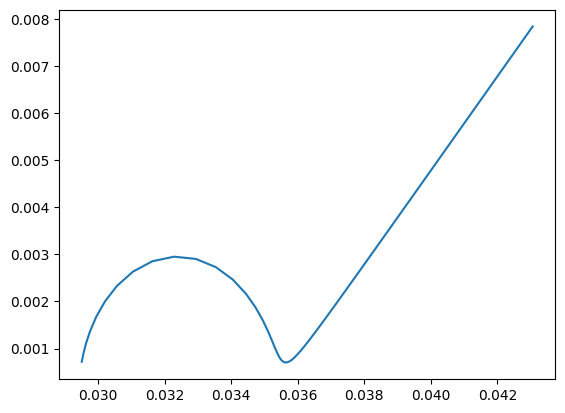

In [37]:
R_el = opt.x[0] #Electrolyte resistance (Ohms)
R_ct = opt.x[1] #Charge transfer resistance (Ohms)
C_dl = opt.x[2] #Double layer capicitance (Farads)
A = opt.x[3] #Warburg coefficient 
L = opt.x[4]

Z_W = w_imp(ang_freq, A)
Z_cdl = w_cap(ang_freq, C_dl)

# Impedance from the Randles circuit 
def Z_randles(): 
    Z = L + R_el + 1/(1/(R_ct + Z_W) + 1/Z_cdl) #correct?
    return Z  

plt.plot(Z_randles().real, -Z_randles().imag)
plt.show()

49 49


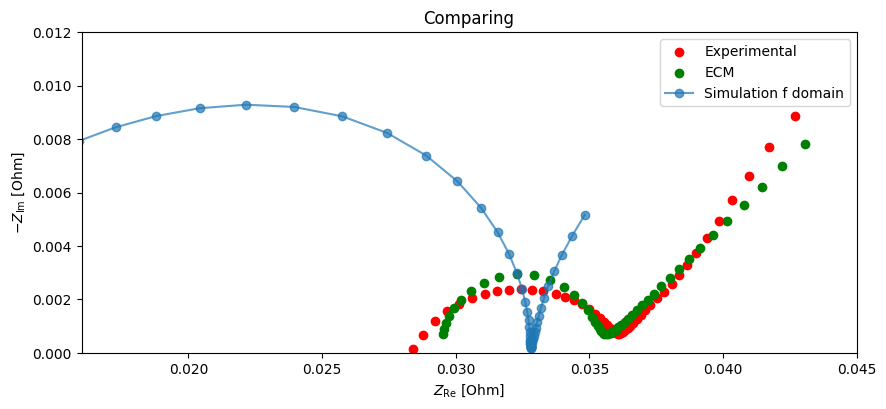

In [38]:
names = ['Experimental', 'Simulation f domain', 'Simulation t domain']

print(len(df_real), len(sim_f))
fig, ax = plt.subplots(figsize=(10, 10)) 
ax.scatter(df_real, -df_imag, label=f"{names[0]}", color = 'red') 
ax.scatter(Z_randles().real, -Z_randles().imag, label = f'ECM', color = 'green')
pybammeis.nyquist_plot(sim_f, ax=ax, linestyle="-", label=f"{names[1]}", alpha=0.7)
#pybammeis.nyquist_plot(impedances_time, ax=ax, linestyle="-", label=f"{names[2]}", alpha=0.7)

ax.set_xlim(0.016, 0.045) 
ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 

Bode plot for the experimental and simulated EIS

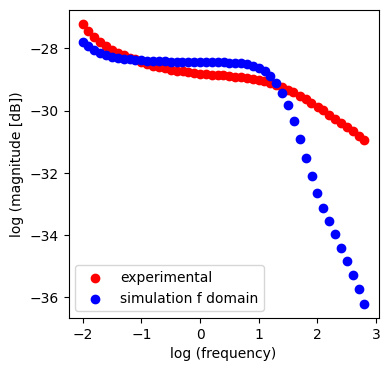

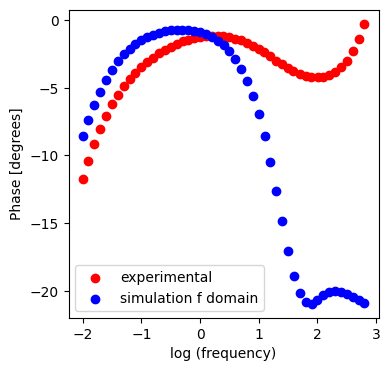

In [53]:
# Magnitude and phase of the simulated EIS: 
sim_f_mag = np.abs(sim_f)
sim_t_mag = np.abs(impedances_time)

sim_f_phz = np.angle(sim_f)*180/np.pi # to convert to degrees 
sim_t_phz = np.angle(impedances_time)*180/np.pi # to convert to degrees 

grense = 32
# Magnitude plot
fig, ax = plt.subplots(figsize=(4, 4)) 
ax.scatter(np.log10(freq), 20*np.log10(df_mag), color = 'red', label = 'experimental') 
ax.scatter(np.log10(frequencies), 20*np.log10(sim_f_mag), color = 'blue', label = 'simulation f domain') 
#ax.scatter(np.log10(frequencies), 20*np.log10(sim_t_mag), color = 'green', label = 'simulation t domain') 
#ax.set_xscale('log')
ax.set_xlabel('log (frequency)')
ax.set_ylabel('log (magnitude [dB])')
#ax.set_xlim(1, 10**5)
plt.legend()
plt.show() 

# Phase plot
fig, ax = plt.subplots(figsize=(4, 4)) 
ax.scatter(np.log10(freq), df_phz, color = 'red', label = 'experimental')
ax.scatter(np.log10(frequencies), sim_f_phz, color = 'blue', label = 'simulation f domain')
#ax.set_xscale('log')
ax.set_xlabel('log (frequency)')
ax.set_ylabel('Phase [degrees]')
#ax.set_xlim(1, 10**5)
plt.legend()
plt.show() 
